# Psychological State Identification using Bayesian Networks
This notebook implements the Bayesian Network approach described in the project document
to classify psychological states (Stressed, Relaxed, Focused, Anxious) based on
simulated multimodal data from the [Kaggle dataset](https://www.kaggle.com/datasets/ziya07/psychological-state-identification-dataset).
# Methodology:
1. Load and preprocess the data.
2. Perform feature extraction and encoding.
3. Split data into training and testing sets.
4. Learn the Bayesian Network structure using Hill Climbing with BIC score.
5. Learn the parameters (CPDs) using Maximum Likelihood Estimation (MLE).
6. Perform inference on the test set using Variable Elimination.
7. Evaluate the model's classification performance.
8. Visualize the learned network structure.

## 1. Setup and Imports
Import necessary libraries. Ensure you have `pgmpy`, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, and `networkx` installed.


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

# pgmpy imports
from pgmpy.models import DiscreteBayesianNetwork # ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.
from pgmpy.estimators import HillClimbSearch, BIC, K2, MaximumLikelihoodEstimator, PC # BIC instead of BicScore, for some reason pgmpy docs are outdated wtf
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Data Loading and Initial Exploration

In [ ]:
DATASET_PATH = 'simulated_psychological_data_v3.csv'
ORIGINAL_TARGET = 'Psychological State'
NEW_TARGET = 'State Group'
TEST_SIZE = 0.20
RANDOM_STATE = 21 # for reproducibility
N_BINS = 5 # Number of bins for discretizing continuous features

# --- Load Data ---
try:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print("Please update the DATASET_PATH variable.")
    # Exit or raise error if file not found
    exit() # Or raise FileNotFoundError("Dataset file not found")

# Display basic info and first few rows
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

# Initial NaN fill for numerical columns in the raw dataframe
print("\nMissing values BEFORE initial fill:")
print(df.isnull().sum().sort_values(ascending=False).head()) # Show top 5 columns with most NaNs
numerical_cols_initial = df.select_dtypes(include=np.number).columns
for col in numerical_cols_initial:
    if df[col].isnull().any(): # Check if column actually has NaNs before filling
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled NaNs in raw numerical column '{col}' with median: {median_val}")

print("\nMissing values AFTER initial fill on raw numerical columns:")
print(df.isnull().sum().sort_values(ascending=False).head()) # Show top 5 again

Dataset loaded successfully.
Shape: (1000, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Task Type                  1000 non-null   object 
 1   Cognitive Load             1000 non-null   object 
 2   Psychological State        1000 non-null   object 
 3   Ambient Noise (dB)         961 non-null    float64
 4   Heart Rate (BPM)           927 non-null    float64
 5   HRV (ms)                   957 non-null    float64
 6   GSR (μS)                   958 non-null    float64
 7   EEG_Delta                  939 non-null    float64
 8   EEG_Alpha                  953 non-null    float64
 9   EEG_Beta                   956 non-null    float64
 10  Skin Temp (°C)             942 non-null    float64
 11  BP_Systolic                950 non-null    float64
 12  Focus Duration (s)         947 non-null    

## 3. Data Preprocessing and Feature Engineering
- Extract features from 'EEG Power Bands' and 'Blood Pressure (mmHg)'.
- Drop columns not used for modeling ('ID', 'Time', 'Study Major').
- Encode categorical features using Label Encoding.

In [3]:
df_processed = df.copy()

# --- Feature Extraction (Assuming columns like EEG_Delta, BP_Systolic are already in df_processed from the simulation) ---
print("\n--- Verifying Expected Features ---")
# Columns that should ideally be present from your simulation or prior extraction
expected_features = ['EEG_Delta', 'EEG_Alpha', 'EEG_Beta', 'BP_Systolic', 'BP_Diastolic',
                     'HRV (ms)', 'GSR (μS)', 'Heart Rate (BPM)', 'Respiration Rate (BPM)',
                     'Skin Temp (°C)', 'Ambient Noise (dB)', 'Ambient Light (lux)',
                     'Room Temperature (°C)', 'Focus Duration (s)', 'Typing Speed (WPM)',
                     'Click/Interaction Freq)', 'Perceived Task Difficulty', 'Age',
                     'Mood State', 'Cognitive Load', 'Task Type', 'Gender', 'Educational Level']
for col_check in expected_features:
    if col_check not in df_processed.columns:
        print(f"Note: Column '{col_check}' not found in the loaded CSV. It will be skipped if not present.")

# --- Group Target Classes ---
print("\n--- Grouping Target Classes ---")
# ORIGINAL_TARGET is 'Psychological State', NEW_TARGET is 'State_Group'
if ORIGINAL_TARGET in df_processed.columns:
    class_mapping = {
        'Stressed': 'Agitated',
        'Anxious': 'Agitated',
        'Relaxed': 'Calm_Engaged',
        'Focused': 'Calm_Engaged'
    }
    df_processed[NEW_TARGET] = df_processed[ORIGINAL_TARGET].map(class_mapping)
    # Handle any original target labels not in the mapping (e.g., if 'Unknown_Target_State' was filled)
    df_processed[NEW_TARGET].fillna('Unknown_Group', inplace=True)
    df_processed = df_processed.drop(columns=[ORIGINAL_TARGET]) # Drop the original target
    print(f"Created new target '{NEW_TARGET}':")
    print(df_processed[NEW_TARGET].value_counts())
else:
    print(f"Error: Original target column '{ORIGINAL_TARGET}' not found in DataFrame.")
    exit()

# --- Identify Feature Types & Robust NaN Handling ---
print("\n--- Identifying Feature Types and Handling NaNs/Infs ---")
# Numerical columns: all columns that are not object/category and not the NEW_TARGET
numerical_cols = [
    col for col in df_processed.columns
    if df_processed[col].dtype != 'object' and df_processed[col].dtype != 'category' and col != NEW_TARGET
]
# Add known numericals that might have been read as object if they had mixed types initially
potential_num_features_from_sim = ['HRV (ms)', 'GSR (μS)', 'EEG_Delta', 'EEG_Alpha', 'EEG_Beta',
                                   'BP_Systolic', 'BP_Diastolic', 'Oxygen Saturation (%)',
                                   'Heart Rate (BPM)', 'Skin Temp (°C)',
                                   'Ambient Noise (dB)', 'Ambient Light (lux)', 'Room Temperature (°C)',
                                   'Focus Duration (s)', 'Typing Speed (WPM)', 'Click/Interaction Freq',
                                   'Perceived Task Difficulty', 'Age']
for p_num_col in potential_num_features_from_sim:
    if p_num_col in df_processed.columns and p_num_col not in numerical_cols:
        numerical_cols.append(p_num_col)
numerical_cols = sorted(list(set(numerical_cols)))

print(f"Numerical columns targeted for processing: {numerical_cols}")

for col in numerical_cols:
    if col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        df_processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            if pd.isna(median_val): median_val = 0
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"Filled NaNs/Infs in numerical column '{col}' with: {median_val:.2f}")

# Categorical columns: all remaining non-target columns that are not numeric
all_cols_set = set(df_processed.columns)
non_target_cols_set = all_cols_set - {NEW_TARGET}
final_numerical_cols = [col for col in df_processed.select_dtypes(include=np.number).columns if col != NEW_TARGET] # Re-check after to_numeric
categorical_cols = sorted(list(non_target_cols_set - set(final_numerical_cols)))

print(f"\nFinal numerical columns (for discretization): {final_numerical_cols}")
print(f"Final categorical columns (features): {categorical_cols}")

# Fill NaNs in remaining categorical feature columns and the new target column if any NaNs persist
for col in categorical_cols:
    if col in df_processed.columns and df_processed[col].isnull().any():
        df_processed[col] = df_processed[col].fillna('Missing_Cat_Value')
        print(f"Filled NaNs in categorical feature '{col}' with 'Missing_Cat_Value'")

if df_processed[NEW_TARGET].isnull().any() or (df_processed[NEW_TARGET] == 'Unknown_Group').any():
    # If 'Unknown_Group' exists, it means some original target values weren't in the mapping.
    # We'll treat these as a distinct category or fill them. For now, fill with a placeholder.
    df_processed[NEW_TARGET].replace('Unknown_Group', 'Other_Group', inplace=True) # Or map to majority/minority
    df_processed[NEW_TARGET] = df_processed[NEW_TARGET].fillna('Other_Group')
    print(f"Handled/Filled NaNs or unmapped values in target '{NEW_TARGET}' with 'Other_Group'")


# --- Data Splitting ---
X = df_processed.drop(NEW_TARGET, axis=1)
y = df_processed[NEW_TARGET] # Use the NEW grouped target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nSplit data shapes: Train X={X_train.shape}, Test X={X_test.shape}")

# --- Discretization (Fit on Train, Transform Train & Test) ---
numerical_cols_for_discretization = [col for col in final_numerical_cols if col in X_train.columns]
print(f"\n--- Discretizing Numerical Features ({N_BINS} bins) ---")
print(f"Numerical columns for discretization: {numerical_cols_for_discretization}")

if numerical_cols_for_discretization:
    # Final check for NaNs in the exact data subset to be discretized in X_train
    for col in numerical_cols_for_discretization:
        if X_train[col].isnull().any():
            median_val_train = X_train[col].median()
            if pd.isna(median_val_train): median_val_train = 0
            print(f"Warning: NaNs found in X_train['{col}'] before discretization. Filling with train median: {median_val_train:.2f}")
            X_train[col] = X_train[col].fillna(median_val_train)
            # Apply same median to X_test for consistency
            if X_test[col].isnull().any():
                 X_test[col] = X_test[col].fillna(median_val_train)


    discretizer = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform', subsample=None, random_state=RANDOM_STATE)
    discretizer.fit(X_train[numerical_cols_for_discretization])
    X_train_num_discretized_vals = discretizer.transform(X_train[numerical_cols_for_discretization])
    X_test_num_discretized_vals = discretizer.transform(X_test[numerical_cols_for_discretization])

    X_train_num_discretized_df = pd.DataFrame(X_train_num_discretized_vals, columns=numerical_cols_for_discretization, index=X_train.index).astype(int)
    X_test_num_discretized_df = pd.DataFrame(X_test_num_discretized_vals, columns=numerical_cols_for_discretization, index=X_test.index).astype(int)

    X_train_processed = X_train.drop(columns=numerical_cols_for_discretization).join(X_train_num_discretized_df)
    X_test_processed = X_test.drop(columns=numerical_cols_for_discretization).join(X_test_num_discretized_df)
    print("Discretization complete.")
else:
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    print("No numerical columns found/left for discretization.")


# --- Encode ALL Features (Categorical + Discretized Numerical) and Target ---
print("\n--- Encoding All Features and Target ---")
label_encoders = {}

# Encode feature columns
for col in X_train_processed.columns:
    le = LabelEncoder()
    combined_X_col_data = pd.concat([X_train_processed[col].fillna('Missing_Encode').astype(str),
                                     X_test_processed[col].fillna('Missing_Encode').astype(str)], axis=0)
    le.fit(combined_X_col_data)
    X_train_processed[col] = le.transform(X_train_processed[col].fillna('Missing_Encode').astype(str))
    X_test_processed[col] = le.transform(X_test_processed[col].fillna('Missing_Encode').astype(str))
    label_encoders[col] = le
    print(f"Encoded feature column: {col}")

# Encode target variable (y_train, y_test) which is now NEW_TARGET
le_target = LabelEncoder()
combined_y_data = pd.concat([y_train.fillna('Missing_Target_Encode').astype(str),
                             y_test.fillna('Missing_Target_Encode').astype(str)], axis=0)
le_target.fit(combined_y_data)
y_train_encoded = le_target.transform(y_train.fillna('Missing_Target_Encode').astype(str))
y_test_encoded = le_target.transform(y_test.fillna('Missing_Target_Encode').astype(str))
label_encoders[NEW_TARGET] = le_target # Store encoder for the NEW target
print(f"Encoded target column: {NEW_TARGET}")
if len(le_target.classes_) <= 15:
    mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
    print(f"  Mapping for {NEW_TARGET}: {mapping}")

# Combine encoded features and target for pgmpy
train_data = X_train_processed.join(pd.Series(y_train_encoded, name=NEW_TARGET, index=X_train_processed.index))
test_data = X_test_processed.join(pd.Series(y_test_encoded, name=NEW_TARGET, index=X_test_processed.index))

print("\nLabel Encoding complete.")
print("\nFinal Training Data (encoded first 5 rows):")
print(train_data.head())
print("\nFinal Training Data Info:")
train_data.info()


--- Verifying Expected Features ---
Note: Column 'Ambient Light (lux)' not found in the loaded CSV. It will be skipped if not present.
Note: Column 'Room Temperature (°C)' not found in the loaded CSV. It will be skipped if not present.
Note: Column 'Click/Interaction Freq)' not found in the loaded CSV. It will be skipped if not present.
Note: Column 'Mood State' not found in the loaded CSV. It will be skipped if not present.

--- Grouping Target Classes ---
Created new target 'State Group':
State Group
Agitated        524
Calm_Engaged    476
Name: count, dtype: int64

--- Identifying Feature Types and Handling NaNs/Infs ---
Numerical columns targeted for processing: ['Age', 'Ambient Noise (dB)', 'BP_Diastolic', 'BP_Systolic', 'Click/Interaction Freq', 'EEG_Alpha', 'EEG_Beta', 'EEG_Delta', 'Focus Duration (s)', 'GSR (μS)', 'HRV (ms)', 'Heart Rate (BPM)', 'Perceived Task Difficulty', 'Skin Temp (°C)', 'Typing Speed (WPM)']
Filled NaNs/Infs in numerical column 'Ambient Noise (dB)' with: 

## 4. Data Splitting (verification since splitting done above)
Split the encoded data into training (80%) and testing (20%) sets.


In [4]:
# Ensure train_data and test_data are defined from the previous cell (Cell 3)
if 'train_data' not in locals() or 'test_data' not in locals():
    print("Error: train_data or test_data not defined. Please ensure Cell 3 has been run successfully.")
    # Potentially exit or raise an error
    exit()
else:
    print(f"Final Training data shape: {train_data.shape}")
    print(f"Final Testing data shape: {test_data.shape}")

    # Verify target variable distribution in encoded data
    # NEW_TARGET is 'State_Group' as per Cell 2 & 3 configurations
    if NEW_TARGET in train_data.columns and NEW_TARGET in test_data.columns:
        print(f"\nTarget '{NEW_TARGET}' distribution in training data (encoded):")
        print(train_data[NEW_TARGET].value_counts(normalize=True))
        # Display original labels for clarity if encoder is available
        if 'label_encoders' in locals() and NEW_TARGET in label_encoders:
            print("Mapping (Encoded -> Original):")
            for i, class_name in enumerate(label_encoders[NEW_TARGET].classes_):
                print(f"  {i} -> {class_name}")

        print(f"\nTarget '{NEW_TARGET}' distribution in testing data (encoded):")
        print(test_data[NEW_TARGET].value_counts(normalize=True))
    else:
        print(f"Error: Target variable '{NEW_TARGET}' not found in the processed train_data or test_data columns.")


Final Training data shape: (800, 21)
Final Testing data shape: (200, 21)

Target 'State Group' distribution in training data (encoded):
State Group
0    0.52375
1    0.47625
Name: proportion, dtype: float64
Mapping (Encoded -> Original):
  0 -> Agitated
  1 -> Calm_Engaged

Target 'State Group' distribution in testing data (encoded):
State Group
0    0.525
1    0.475
Name: proportion, dtype: float64


## 5. Bayesian Network Structure Learning
Learn the DAG structure from the training data using the Hill Climbing search algorithm and BIC score.


In [5]:
# Ensure train_data is available from Cell 3
if 'train_data' not in locals():
    print("Error: train_data not found. Please ensure Cell 3 (Preprocessing) has been run successfully.")
    # Potentially exit or raise an error
    exit()

# --- Method: Hill Climb Algorithm with BIC Score ---
print("Starting structure learning using HillClimb algorithm with BIC score...")

# Ensure data is integer type for estimators
# train_data from Cell 3 should already be integer encoded after LabelEncoding all columns.
# Explicitly casting again to int just to be absolutely sure for pgmpy.
train_data_int = train_data.astype(int)

# Initialize scoring method
# BIC class is used directly as BicScore is deprecated/renamed
scorer = BIC(data=train_data_int)
print(f"Using scorer: {scorer.__class__.__name__}")

# Initialize search algorithm
# No white_list or black_list is used in this version.
hc = HillClimbSearch(data=train_data_int)

# Perform the search
best_model_structure = hc.estimate(
    scoring_method=scorer,
    show_progress=True
)
print(f"\nHillClimb Algorithm ({scorer.__class__.__name__} score)")


# --- Output and Model Creation ---
print("\nStructure learning complete.")
learned_edges = sorted(list(best_model_structure.edges())) # best_model_structure is a DAG
print(f"Learned Edges ({len(learned_edges)}):")

# Only print if not too many edges, to keep output clean
if len(learned_edges) == 0:
    print("No edges were learned.")
elif len(learned_edges) < 50: # Arbitrary limit for cleaner output
    print(learned_edges)
else:
    print(f"(Too many edges to print: {len(learned_edges)})")

# Create the Bayesian Network model with the learned structure
model = DiscreteBayesianNetwork(learned_edges) # Use learned edges directly
model.add_nodes_from(train_data.columns) # Ensure all nodes are included even if isolated

print(f"\nModel nodes ({len(model.nodes())}): {model.nodes()}")
if not model.edges():
    print("Warning: The learned model has no edges. Predictions will likely be based on prior probabilities of the target variable only.")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s)': 'N', 'BP_Diastolic': 'N', 'Age': 'N', 'Perceived Task Difficulty': 'N', 'Click/Interaction Freq': 'N', 'Typing Speed (WPM)': 'N', 'State Group': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s)': 'N',

Starting structure learning using HillClimb algorithm with BIC score...
Using scorer: BIC


  0%|          | 0/1000000 [00:00<?, ?it/s]


HillClimb Algorithm (BIC score)

Structure learning complete.
Learned Edges (14):
[('Cognitive Load', 'BP_Diastolic'), ('Cognitive Load', 'BP_Systolic'), ('Cognitive Load', 'EEG_Alpha'), ('Cognitive Load', 'EEG_Delta'), ('Cognitive Load', 'Focus Duration (s)'), ('Cognitive Load', 'GSR (μS)'), ('Cognitive Load', 'HRV (ms)'), ('Cognitive Load', 'Heart Rate (BPM)'), ('Cognitive Load', 'Respiration Rate (BPM)'), ('Cognitive Load', 'Skin Temp (°C)'), ('Cognitive Load', 'State Group'), ('Cognitive Load', 'Task Type'), ('Cognitive Load', 'Typing Speed (WPM)'), ('EEG_Beta', 'Cognitive Load')]

Model nodes (21): ['Cognitive Load', 'BP_Diastolic', 'BP_Systolic', 'EEG_Alpha', 'EEG_Delta', 'Focus Duration (s)', 'GSR (μS)', 'HRV (ms)', 'Heart Rate (BPM)', 'Respiration Rate (BPM)', 'Skin Temp (°C)', 'State Group', 'Task Type', 'Typing Speed (WPM)', 'EEG_Beta', 'Gender', 'Educational Level', 'Ambient Noise (dB)', 'Age', 'Perceived Task Difficulty', 'Click/Interaction Freq']


## 6. Bayesian Network Parameter Learning
Estimate the Conditional Probability Distributions (CPDs) for each node in the learned structure using Maximum Likelihood Estimation (MLE) on the training data.


In [6]:
print("Starting parameter learning (MLE)...")

# Fit the model using MLE
# state_names can be provided if LabelEncoder wasn't used, but it should infer from data
model.fit(
    data=train_data,
    estimator=MaximumLikelihoodEstimator
    # state_names={col: list(label_encoders[col].classes_) for col in categorical_cols if col in label_encoders} # Optional: provide explicit names
)

print("Parameter learning complete.")

# --- Model Validation (Basic Checks) ---
print("\nChecking model structure and parameters...")
try:
    model.check_model()
    print("Model check successful: Structure is valid and CPDs sum to 1.")
except Exception as e:
    print(f"Model check failed: {e}")

# Optionally, print a few CPDs to inspect
print("\nExample CPDs (first 3):")
cpd_count = 0
for cpd in model.get_cpds()[:3]:
    print(f"\nCPD for variable: {cpd.variable}")
    print(cpd)
    cpd_count += 1
if cpd_count == 0:
    print("No CPDs found (check fitting process).")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s)': 'N', 'BP_Diastolic': 'N', 'Age': 'N', 'Perceived Task Difficulty': 'N', 'Click/Interaction Freq': 'N', 'Typing Speed (WPM)': 'N', 'State Group': 'N'}


Starting parameter learning (MLE)...
Parameter learning complete.

Checking model structure and parameters...
Model check successful: Structure is valid and CPDs sum to 1.

Example CPDs (first 3):

CPD for variable: Cognitive Load
+-------------------+-------------+-----+-------------+
| EEG_Beta          | EEG_Beta(0) | ... | EEG_Beta(4) |
+-------------------+-------------+-----+-------------+
| Cognitive Load(0) | 0.0         | ... | 1.0         |
+-------------------+-------------+-----+-------------+
| Cognitive Load(1) | 1.0         | ... | 0.0         |
+-------------------+-------------+-----+-------------+
| Cognitive Load(2) | 0.0         | ... | 0.0         |
+-------------------+-------------+-----+-------------+

CPD for variable: BP_Diastolic
+-----------------+-----+----------------------+
| Cognitive Load  | ... | Cognitive Load(2)    |
+-----------------+-----+----------------------+
| BP_Diastolic(0) | ... | 0.016891891891891893 |
+-----------------+-----+------------

## 7. Inference and Prediction on Test Set
Use the learned model to predict the psychological state for each instance in the test set. We use the Variable Elimination algorithm for exact inference.


In [8]:
print("Starting inference on the test set...")

# Ensure necessary variables from previous cells are available
if 'test_data' not in locals() or 'train_data' not in locals(): # train_data needed for column order
    print("Error: test_data or train_data not found. Please ensure Cell 3 (Preprocessing) has been run successfully.")
    exit()
if 'model' not in locals():
    print("Error: model object not found. Please ensure Cell 5 (Structure Learning) and Cell 6 (Parameter Learning) have been run successfully.")
    exit()
if 'label_encoders' not in locals() or NEW_TARGET not in label_encoders: # Check for NEW_TARGET encoder
    print(f"Error: Label encoder for target variable '{NEW_TARGET}' not found. Ensure Cell 3 ran correctly.")
    exit()


# Prepare test data for prediction (remove target variable)
# Ensure columns are in the same order as X_train_processed was before it became part of train_data
train_feature_columns = [col for col in train_data.columns if col != NEW_TARGET]

try:
    # Ensure X_test_encoded has the same columns in the same order as X_train_processed
    # and is integer type
    X_test_encoded = test_data[train_feature_columns].astype(int)
except KeyError as e:
    print(f"KeyError during X_test_encoded preparation: {e}. One or more columns from training are missing in test_data.")
    print(f"Training feature columns expected: {train_feature_columns}")
    print(f"Test data columns available: {list(test_data.columns)}")
    exit()

y_test_encoded = test_data[NEW_TARGET].astype(int) # Keep encoded grouped target for evaluation

# Initialize inference engine
try:
    inference_engine = VariableElimination(model)
except Exception as e:
    print(f"Error initializing VariableElimination: {e}")
    print("This might happen if the model has no edges or is not properly fitted.")
    exit()

# Predict probabilities for each class
y_pred_probs = None # Initialize
y_pred_labels_encoded = [] # Store encoded predictions

# Store original decoded labels for final report (using the NEW_TARGET encoder)
y_test_labels = label_encoders[NEW_TARGET].inverse_transform(y_test_encoded)


# Attempt batch prediction
try:
    print("Attempting batch prediction...")
    # Predict most likely state (encoded)
    # The predict method returns a DataFrame with the predicted variable as column name
    y_pred_encoded_df = model.predict(X_test_encoded, n_jobs=-1)
    y_pred_labels_encoded = y_pred_encoded_df[NEW_TARGET].values # Use NEW_TARGET

    # Predict probabilities
    print("Predicting probabilities...")
    y_pred_probs_df = model.predict_probability(X_test_encoded, n_jobs=-1)

    # Ensure probability columns are in the correct order of the NEW_TARGET classes
    # Get the encoded class values as sorted based on the NEW_TARGET LabelEncoder
    sorted_encoded_classes = sorted(label_encoders[NEW_TARGET].transform(label_encoders[NEW_TARGET].classes_))
    
    # Construct column names as pgmpy typically creates them (NEW_TARGET_encodedvalue)
    prob_cols_ordered = [f"{NEW_TARGET}_{enc_val}" for enc_val in sorted_encoded_classes]

    available_cols = y_pred_probs_df.columns.tolist()
    cols_to_use = [col for col in prob_cols_ordered if col in available_cols]
    missing_cols = [col for col in prob_cols_ordered if col not in available_cols]

    if missing_cols:
        print(f"Warning: Expected probability columns missing from predict_probability output: {missing_cols}")
        print(f"Available probability columns: {available_cols}")
        if len(cols_to_use) == len(sorted_encoded_classes):
            y_pred_probs = y_pred_probs_df[cols_to_use].values
            print("Successfully used available probability columns by reordering.")
        else:
            print("Could not reliably order probability columns due to missing ones or count mismatch. Setting probabilities to None.")
            y_pred_probs = None
    else:
         y_pred_probs = y_pred_probs_df[prob_cols_ordered].values
         print("Batch prediction for probabilities successful.")

    print("Batch prediction for labels successful.")

except Exception as e:
    print(f"An unexpected error occurred during batch prediction ({e}). Falling back to row-by-row inference (slower)...")
    y_pred_probs_list = []
    y_pred_labels_encoded = [] # Reset for row-by-row
    
    X_test_for_row_inference = test_data.drop(columns=[NEW_TARGET]).astype(int)

    for index, row_data in X_test_for_row_inference.iterrows():
        try:
            evidence = row_data.to_dict()
            prob_dist = inference_engine.query(variables=[NEW_TARGET], evidence=evidence, show_progress=False) # Query for NEW_TARGET
            probs = prob_dist.values
            predicted_state_encoded = np.argmax(probs)
            y_pred_labels_encoded.append(predicted_state_encoded)
            y_pred_probs_list.append(probs)
        except Exception as query_error:
            print(f"Error during row-by-row inference for row {index}: {query_error}")
            if "is an unknown state for variable" in str(query_error):
                print(f"  >> Details: {query_error}")
            y_pred_labels_encoded.append(np.nan)
            num_classes = len(label_encoders[NEW_TARGET].classes_) # Use NEW_TARGET classes
            y_pred_probs_list.append([np.nan] * num_classes)

    y_pred_probs = np.array(y_pred_probs_list)
    y_pred_labels_encoded = np.array(y_pred_labels_encoded)

print("\nInference complete.")

# Decode predicted labels (handle potential NaNs from errors)
valid_preds_indices = ~np.isnan(y_pred_labels_encoded)
y_pred_labels = np.full(len(y_test_labels), fill_value='Error_Pred_Decode', dtype=object)
if np.any(valid_preds_indices):
     valid_preds_encoded_int = y_pred_labels_encoded[valid_preds_indices].astype(int)
     max_known_label_idx = len(label_encoders[NEW_TARGET].classes_) - 1
     if np.any(valid_preds_encoded_int > max_known_label_idx) or np.any(valid_preds_encoded_int < 0):
         print(f"Warning: Some predicted encoded labels are outside the known range [0, {max_known_label_idx}] for '{NEW_TARGET}'. Clipping them.")
         valid_preds_encoded_int = np.clip(valid_preds_encoded_int, 0, max_known_label_idx)
     y_pred_labels[valid_preds_indices] = label_encoders[NEW_TARGET].inverse_transform(valid_preds_encoded_int)

print(f"\nFirst 5 decoded predictions: {y_pred_labels[:5]}")
print(f"First 5 actual decoded labels: {y_test_labels[:5]}")

if 'Error_Pred_Decode' in y_pred_labels:
    print("\nWarning: Some predictions could not be decoded, likely due to errors during inference.")


Starting inference on the test set...
Attempting batch prediction...


  0%|          | 0/200 [00:00<?, ?it/s]

Predicting probabilities...
An unexpected error occurred during batch prediction (DiscreteBayesianNetwork.predict_probability() got an unexpected keyword argument 'n_jobs'). Falling back to row-by-row inference (slower)...

Inference complete.

First 5 decoded predictions: ['Calm_Engaged' 'Calm_Engaged' 'Agitated' 'Calm_Engaged' 'Agitated']
First 5 actual decoded labels: ['Calm_Engaged' 'Agitated' 'Calm_Engaged' 'Calm_Engaged' 'Agitated']


## 8. Model Evaluation
Evaluate the classifier's performance using accuracy, classification report (precision, recall, F1-score), confusion matrix, and AUC (Area Under the ROC Curve) on the **encoded and discretized** data.


Evaluating model performance (for grouped classes)...

Overall Accuracy (for 'State Group'): 0.8000

Classification Report (for 'State Group'):
              precision    recall  f1-score   support

    Agitated       0.88      0.71      0.79       105
Calm_Engaged       0.74      0.89      0.81        95

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200


Confusion Matrix (for 'State Group'):
[[75 30]
 [10 85]]


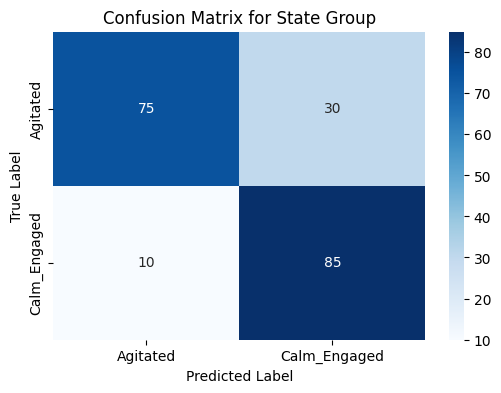


AUC Score (for positive class 'Agitated'): 0.8767


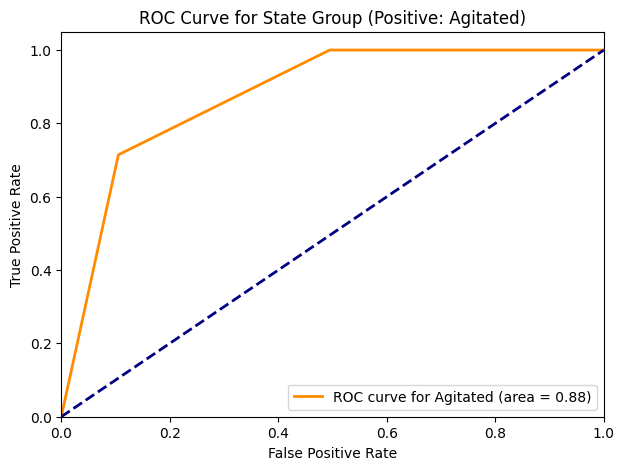

In [12]:
print("Evaluating model performance (for grouped classes)...")

# Ensure necessary variables from previous cells are available
if 'y_test_labels' not in locals() or 'y_pred_labels' not in locals() or \
   'y_test_encoded' not in locals() or 'y_pred_probs' not in locals() or \
   'label_encoders' not in locals() or NEW_TARGET not in label_encoders: # Check for NEW_TARGET
    print("Error: One or more required variables for evaluation not found.")
    print("Please ensure Cells 3, and 7 (for grouped target) have been run successfully.")
    exit()

# Filter out any instances where prediction failed (resulted in 'Error_Pred_Decode' or NaN in probabilities)
# 1. Identify valid predictions based on y_pred_labels
valid_label_indices = (y_pred_labels != 'Error_Pred_Decode')

# 2. Identify valid probabilities (not NaN)
if y_pred_probs is not None:
    if y_pred_probs.ndim > 1: # Should be 2D for binary (probs for class 0, probs for class 1)
        valid_prob_indices = ~np.isnan(y_pred_probs).any(axis=1)
    else: # Unlikely for binary probabilities from pgmpy, but handle
        valid_prob_indices = ~np.isnan(y_pred_probs)
    combined_valid_indices = valid_label_indices & valid_prob_indices
else:
    combined_valid_indices = valid_label_indices
    print("Warning: y_pred_probs is None. AUC calculation will be skipped.")


y_test_labels_filtered = y_test_labels[combined_valid_indices]
y_pred_labels_filtered = y_pred_labels[combined_valid_indices]
y_test_encoded_filtered = y_test_encoded[combined_valid_indices] # This is the encoded (0 or 1) version

if y_pred_probs is not None:
    y_pred_probs_filtered = y_pred_probs[combined_valid_indices]
else:
    y_pred_probs_filtered = None


if len(y_test_labels_filtered) == 0:
    print("Error: No valid predictions available for evaluation after filtering errors/NaNs.")
else:
    # --- Accuracy ---
    accuracy = accuracy_score(y_test_labels_filtered, y_pred_labels_filtered)
    print(f"\nOverall Accuracy (for '{NEW_TARGET}'): {accuracy:.4f}")

    # --- Classification Report ---
    print(f"\nClassification Report (for '{NEW_TARGET}'):")
    # Use the actual string labels for the report for better readability
    report_labels = sorted(list(set(y_test_labels_filtered) | set(y_pred_labels_filtered)))
    if 'Error_Pred_Decode' in report_labels: # Should have been filtered, but as a safeguard
        report_labels.remove('Error_Pred_Decode')
    
    print(classification_report(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels, target_names=report_labels, zero_division=0))

    # --- Confusion Matrix ---
    print(f"\nConfusion Matrix (for '{NEW_TARGET}'):")
    cm_data = confusion_matrix(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels)
    print(cm_data)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4)) # Adjusted for binary classification
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues',
                xticklabels=report_labels, yticklabels=report_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {NEW_TARGET}')
    plt.show()

    # --- AUC (Area Under the ROC Curve) - For Binary Classification ---
    # Ensure we have two classes in our report_labels for binary AUC
    n_classes_report = len(report_labels)
    
    if n_classes_report == 2 and y_pred_probs_filtered is not None and \
       y_pred_probs_filtered.shape[0] == len(y_test_encoded_filtered) and \
       y_pred_probs_filtered.shape[1] == 2: # Probabilities should have 2 columns for binary
        try:
            # Determine the encoded value for the "positive" class.
            # Let's assume 'Agitated' is our positive class for AUC.
            # You might need to adjust this if your label encoder encodes them differently.
            positive_class_label = 'Agitated' # Or 'Calm_Engaged'
            
            if positive_class_label in label_encoders[NEW_TARGET].classes_:
                positive_class_encoded = label_encoders[NEW_TARGET].transform([positive_class_label])[0]
                
                # Probabilities for the positive class.
                # The column index in y_pred_probs_filtered corresponds to the encoded class value.
                # If 'Agitated' is encoded as 1, use column 1. If 0, use column 0.
                # This assumes y_pred_probs_df columns were ordered by sorted encoded class values (0 then 1)
                # or that the order matches label_encoders[NEW_TARGET].classes_ if it was sorted.
                # A robust way: find which column corresponds to the positive_class_encoded
                
                # Get the order of classes as used by the probability columns
                # This assumes predict_probability column names are like 'State_Group_0', 'State_Group_1'
                # and sorted_encoded_classes from Cell 7 was correct.
                prob_class_order_encoded = sorted(label_encoders[NEW_TARGET].transform(label_encoders[NEW_TARGET].classes_))
                
                if positive_class_encoded in prob_class_order_encoded:
                    positive_class_prob_index = prob_class_order_encoded.index(positive_class_encoded)
                    y_pred_probs_auc = y_pred_probs_filtered[:, positive_class_prob_index]

                    # True labels binarized according to the positive class
                    y_test_binary_for_auc = (y_test_encoded_filtered == positive_class_encoded).astype(int)

                    auc_score_val = roc_auc_score(y_test_binary_for_auc, y_pred_probs_auc)
                    print(f"\nAUC Score (for positive class '{positive_class_label}'): {auc_score_val:.4f}")

                    fpr, tpr, _ = roc_curve(y_test_binary_for_auc, y_pred_probs_auc)
                    plt.figure(figsize=(7, 5))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for {positive_class_label} (area = {auc_score_val:.2f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title(f'ROC Curve for {NEW_TARGET} (Positive: {positive_class_label})')
                    plt.legend(loc="lower right")
                    plt.show()
                else:
                    print(f"Warning: Encoded positive class '{positive_class_encoded}' for AUC not found in probability column order. Skipping AUC plot.")
            else:
                 print(f"Warning: Positive class '{positive_class_label}' for AUC not found in label encoder. Skipping AUC plot.")
        except ValueError as ve:
             print(f"\nCould not calculate AUC due to ValueError: {ve}")
             print("  This can happen if only one class is present in the test labels after filtering, or if probabilities are malformed.")
        except Exception as e:
            print(f"\nCould not calculate AUC due to unexpected error: {e}")
    else:
        print("\nAUC calculation skipped or conditions not met for binary AUC.")
        if n_classes_report != 2: print(f"  Reason: Not a binary classification problem based on report_labels (found {n_classes_report} classes).")
        if y_pred_probs_filtered is None: print("  Reason: Probabilities not available/valid.")
        elif y_pred_probs_filtered.shape[0] != len(y_test_encoded_filtered): print(f"  Reason: Mismatched probability/label shapes after filtering: Probs {y_pred_probs_filtered.shape[0]}, Labels {len(y_test_encoded_filtered)}")
        elif n_classes_report == 2 and y_pred_probs_filtered.shape[1] != 2 : print(f"  Reason: Probability array columns ({y_pred_probs_filtered.shape[1]}) not 2 for binary case.")


## 9. Visualize Learned Network Structure
Display the learned Directed Acyclic Graph (DAG).


Visualizing learned network structure...
Using graphviz layout (neato).


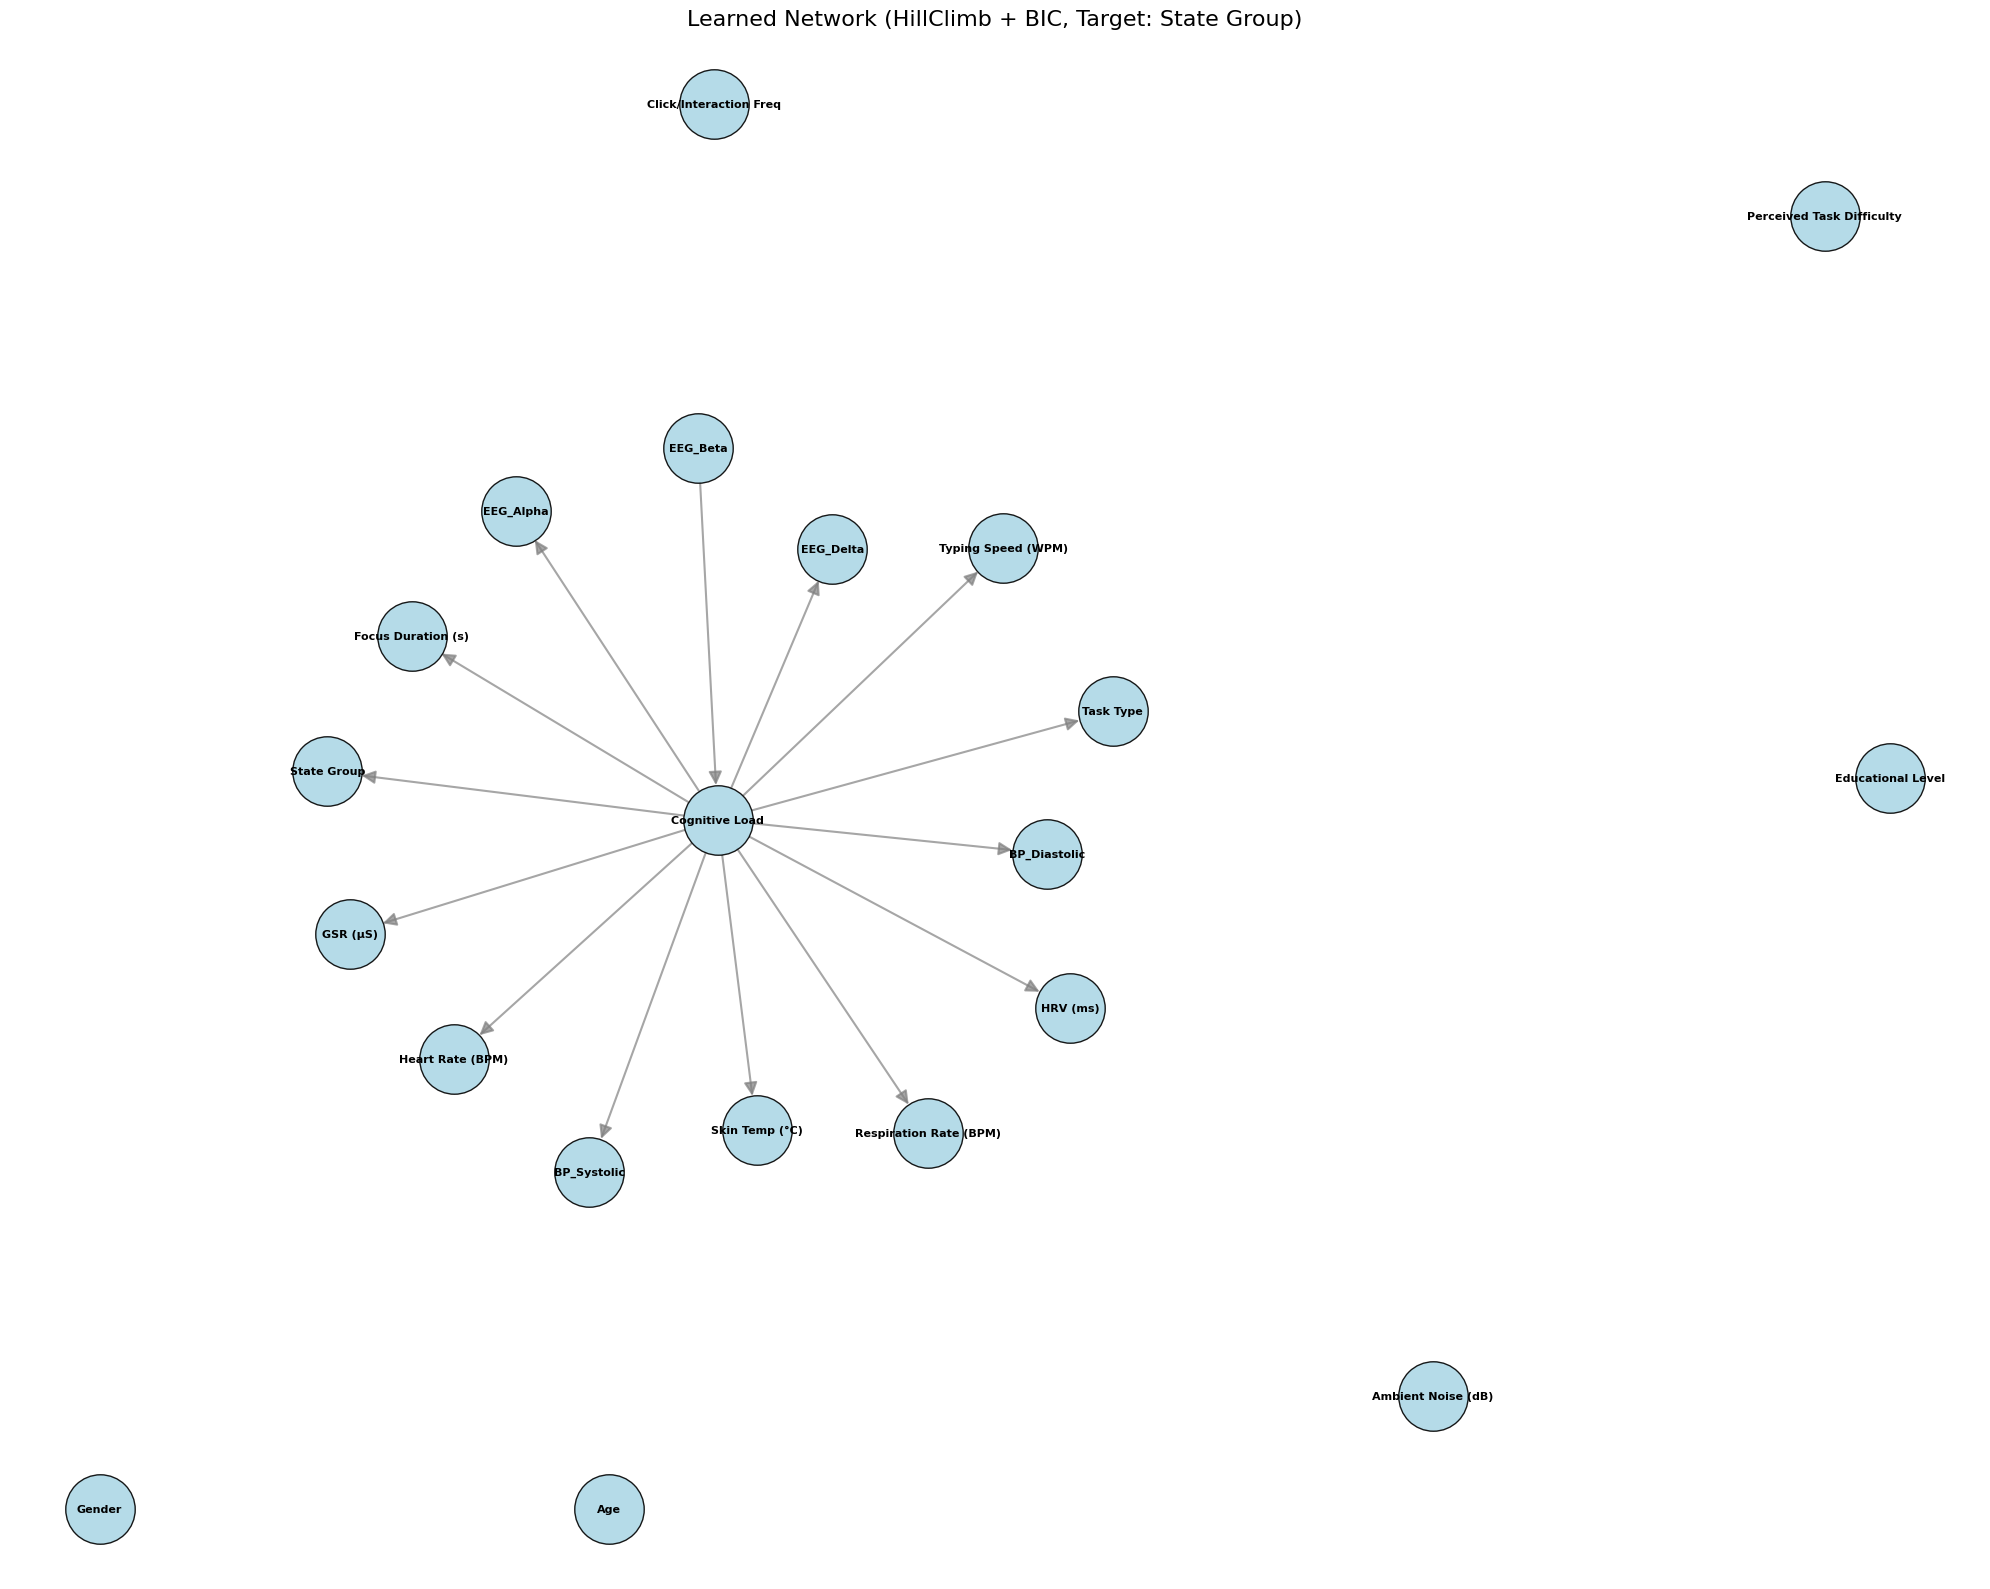

Visualization complete.


In [ ]:
print("\nVisualizing learned network structure...")

# Ensure the model object is available from Cell 5
if 'model' not in locals() or not hasattr(model, 'nodes') or not hasattr(model, 'edges'):
    print("Error: model object not found or is not a valid pgmpy model.")
    print("Please ensure Cell 5 (Structure Learning) and Cell 6 (Parameter Learning) have been run successfully.")
    # Potentially exit or raise an error
    exit()

plt.figure(figsize=(20, 16)) # Adjust size as needed for clarity

# Determine the title based on which structure learning method was active in Cell 5
plot_title = f"Learned Bayesian Network Structure for {NEW_TARGET} (Discretized Data)" # Default title

# Heuristic to refine title based on variables likely set in Cell 5
if 'hc' in locals() and isinstance(hc, HillClimbSearch):
    scorer_name = "UnknownScorer"
    if 'scorer' in locals() and hasattr(scorer, '__class__'):
        scorer_name = scorer.__class__.__name__
    plot_title = f"Learned Network (HillClimb + {scorer_name}, Target: {NEW_TARGET})"
elif 'est' in locals() and isinstance(est, PC):
    sig_level = "Unknown"
    if 'significance_level' in locals(): # Check if significance_level was defined
        sig_level = significance_level
    plot_title = f"Learned Network (PC Algorithm, sig_level={sig_level}, Target: {NEW_TARGET})"


try:
    # Use a layout algorithm that handles larger graphs better
    pos = nx.nx_agraph.graphviz_layout(model, prog='neato') # 'neato', 'dot', 'fdp', 'sfdp', 'twopi', 'circo'
    print("Using graphviz layout (neato).")
except ImportError:
    print("Graphviz/pygraphviz/pydot not found, using alternative layout (kamada_kawai).")
    print("For potentially better layouts, install graphviz and its Python interface (e.g., `pip install pygraphviz` or `pip install pydot`).")
    pos = nx.kamada_kawai_layout(model) # A good fallback
except Exception as layout_err:
     print(f"Graphviz layout failed ({layout_err}), using basic spring_layout as fallback.")
     pos = nx.spring_layout(model, k=0.15, iterations=20) # Spring layout as a last resort


# Draw nodes
nx.draw_networkx_nodes(model, pos, node_size=2500, node_color='lightblue', alpha=0.9, linewidths=1.0, edgecolors='black')

# Draw edges
if model.edges():
    nx.draw_networkx_edges(
        model, pos,
        edgelist=model.edges(),
        arrowstyle='-|>', # Standard arrow
        arrowsize=20,    # Size of the arrowhead
        edge_color='gray',
        alpha=0.7,
        node_size=2500,  # Helps position arrows relative to node size
        width=1.5        # Edge line width
    )
else:
    print("No edges found in the model to draw.")

# Draw labels
nx.draw_networkx_labels(model, pos, font_size=8, font_weight='bold')

plt.title(plot_title, fontsize=16)
plt.axis('off') # Turn off the axis numbers and ticks
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()

print("Visualization complete.")